The objective of the following article is to obtain a step-by-step guide on building the `Dynamic Standard Theta Method` using `DynamicTheta` with `Statsforecast`.

During this walkthrough, we will become familiar with the main `StatsForecast` class and some relevant methods such as `StatsForecast.plot`, `StatsForecast.forecast` and `StatsForecast.cross_validation` in other.

Let's start!!!

<a class="anchor" id="0.1"></a>
# **Table of Contents** 


1.	[Introduction](#1)
2.	[Dynamic Standard Theta Method(DSTM) ](#2)
3.	[Installing Statsforecast](#3)
4.	[Loading libraries and data](#4)
5.	[Explore Data with the plot method](#5)
6.	[Split the data into training and testing](#6)
7.	[Implementation of Theta with StatsForecast](#7)
8.	[Evaluate the model’s performance](#8)
9.	[Evaluate the model](#9)
10. [References](#10)

# **1. Introduction** <a class="anchor" id="1"></a>

[Table of Contents](#0)





# **2. Dynamic Standard Theta Models (DSTM)** <a class="anchor" id="2"></a>

[Table of Contents](#0)

The Dynamic Standard Theta Model is a case-specific variation of the Optimized Dynamic Theta Model (see documentation).

Also, for $\theta=2$, we have a stochastic approach of Theta, which is referred to hereafter as the dynamic standard Theta model (DSTM).

# **3. Installing Statsforecast** <a class="anchor" id="3"></a>

[Table of Contents](#0.1)

* using pip:

`pip install statsforecast`

* using with conda:

`conda install -c conda-forge statsforecast`

¡Warning!

We are constantly updating StatsForecast, so we suggest fixing the version to avoid issues. 

`pip install statsforecast=="1.0.0"`

# **4. Loading libraries and data** <a class="anchor" id="4"></a>

[Table of Contents](#0.1)

In [1]:
# Handling and processing of Data
# ==============================================================================
import numpy as np
import pandas as pd

import scipy.stats as stats

# Handling and processing of Data for Date (time)
# ==============================================================================
import datetime
import time
from datetime import datetime, timedelta


In [2]:
# Plot
# ==============================================================================
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
import plotly.express as px
import plotly.graph_objects as go
plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.5
dark_style = {
    'figure.facecolor': '#212946',
    'axes.facecolor': '#212946',
    'savefig.facecolor':'#212946',
    'axes.grid': True,
    'axes.grid.which': 'both',
    'axes.spines.left': False,
    'axes.spines.right': False,
    'axes.spines.top': False,
    'axes.spines.bottom': False,
    'grid.color': '#2A3459',
    'grid.linewidth': '1',
    'text.color': '0.9',
    'axes.labelcolor': '0.9',
    'xtick.color': '0.9',
    'ytick.color': '0.9',
    'font.size': 12 }
plt.rcParams.update(dark_style)
# Define the plot size
# ==============================================================================
from pylab import rcParams
rcParams['figure.figsize'] = (18,7)

# Hide warnings
# ==============================================================================
from pylab import rcParams
import warnings
warnings.filterwarnings("ignore")

## **4.1 Read Data**

In [3]:
df = pd.read_csv("https://raw.githubusercontent.com/Naren8520/Serie-de-tiempo-con-Machine-Learning/main/Data/milk_production.csv", usecols=[1,2])
df.head()

,month,production
0,1962-01-01,589
1,1962-02-01,561
2,1962-03-01,640
3,1962-04-01,656
4,1962-05-01,727


The input to StatsForecast is always a data frame in long format with three columns: unique_id, ds and y:

* The `unique_id` (string, int or category) represents an identifier for the series.

* The `ds` (datestamp) column should be of a format expected by Pandas, ideally YYYY-MM-DD for a date or YYYY-MM-DD HH:MM:SS for a timestamp.

* The `y` (numeric) represents the measurement we wish to forecast.

In [4]:
df["unique_id"]="1"
df.columns=["ds", "y", "unique_id"]
df.head()

,ds,y,unique_id
0,1962-01-01,589,1
1,1962-02-01,561,1
2,1962-03-01,640,1
3,1962-04-01,656,1
4,1962-05-01,727,1


In [5]:
df.tail()

,ds,y,unique_id
163,1975-08-01,858,1
164,1975-09-01,817,1
165,1975-10-01,827,1
166,1975-11-01,797,1
167,1975-12-01,843,1


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 168 entries, 0 to 167
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ds         168 non-null    object
 1   y          168 non-null    int64 
 2   unique_id  168 non-null    object
dtypes: int64(1), object(2)
memory usage: 4.1+ KB


We can see that our time variable `(ds)` is in an object format, we need to convert to a date format

In [7]:
# Convert to a datetime format
from datetime import datetime
df["ds"] = pd.to_datetime(df["ds"])

# **5. Explore Data with the plot method** <a class="anchor" id="5"></a>

[Table of Contents](#0.1)

Plot some series using the plot method from the StatsForecast class. This method prints 8 random series from the dataset and is useful for basic EDA.

In [8]:
from statsforecast import StatsForecast

StatsForecast.plot(df, )

## **5.1 Autocorrelation plots**

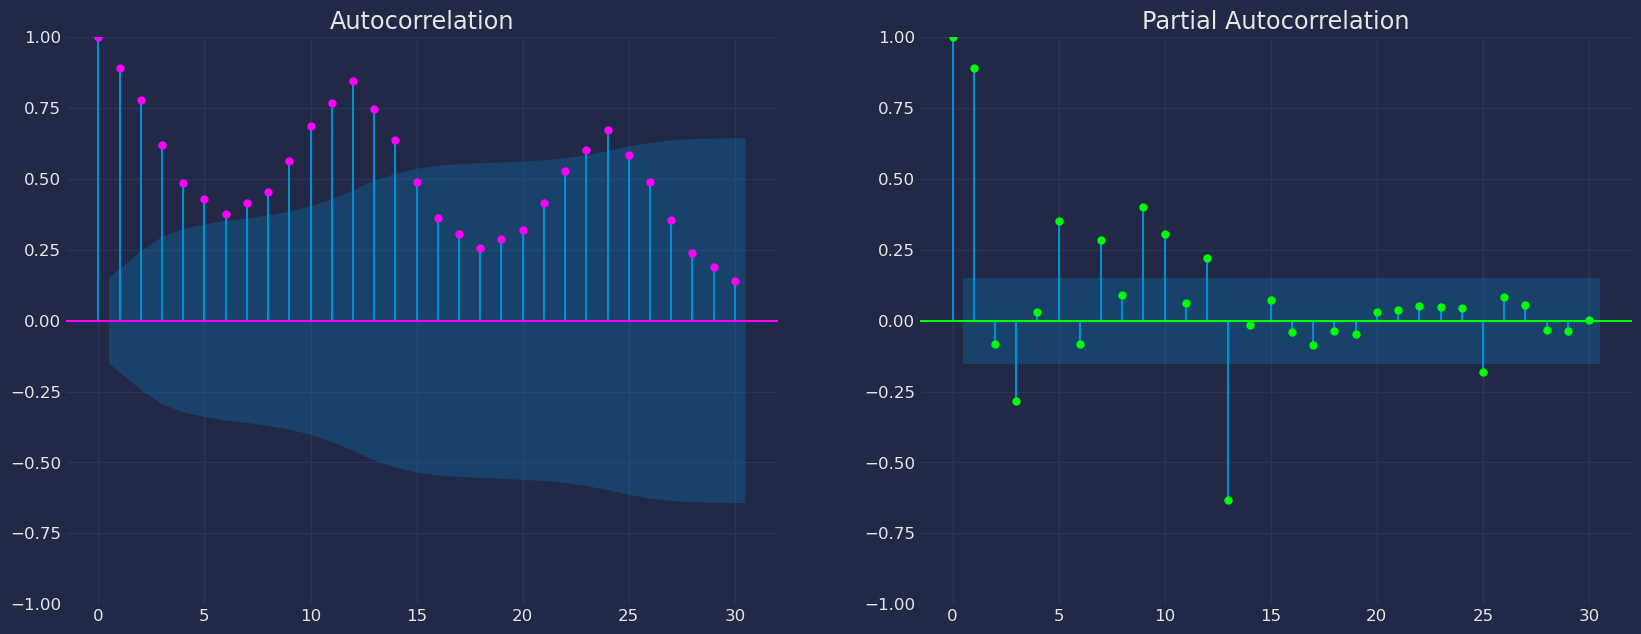

In [9]:
fig, axs = plt.subplots(nrows=1, ncols=2)

plot_acf(df["y"],  lags=30, ax=axs[0],color="fuchsia")
axs[0].set_title("Autocorrelation");

# Grafico
plot_pacf(df["y"],  lags=30, ax=axs[1],color="lime")
axs[1].set_title('Partial Autocorrelation')

#plt.savefig("Gráfico de Densidad y qq")
plt.show();

## **5.2 Decomposition of the time series**

How to decompose a time series and why?

In time series analysis to forecast new values, it is very important to know past data. More formally, we can say that it is very important to know the patterns that values follow over time. There can be many reasons that cause our forecast values to fall in the wrong direction. Basically, a time series consists of four components. The variation of those components causes the change in the pattern of the time series. These components are:

* **Level:** This is the primary value that averages over time.
* **Trend:** The trend is the value that causes increasing or decreasing patterns in a time series.
* **Seasonality:** This is a cyclical event that occurs in a time series for a short time and causes short-term increasing or decreasing patterns in a time series.
* **Residual/Noise:** These are the random variations in the time series.

Combining these components over time leads to the formation of a time series. Most time series consist of level and noise/residual and trend or seasonality are optional values.

If seasonality and trend are part of the time series, then there will be effects on the forecast value. As the pattern of the forecasted time series may be different from the previous time series.

The combination of the components in time series can be of two types:
* Additive
* multiplicative

Additive time series

If the components of the time series are added to make the time series. Then the time series is called the additive time series. By visualization, we can say that the time series is additive if the increasing or decreasing pattern of the time series is similar throughout the series. The mathematical function of any additive time series can be represented by:
$$y(t) = level + Trend + seasonality + noise$$

## Multiplicative time series

If the components of the time series are multiplicative together, then the time series is called a multiplicative time series. For visualization, if the time series is having exponential growth or decline with time, then the time series can be considered as the multiplicative time series. The mathematical function of the multiplicative time series can be represented as.

$$y(t) = Level * Trend * seasonality * Noise$$

### Additive

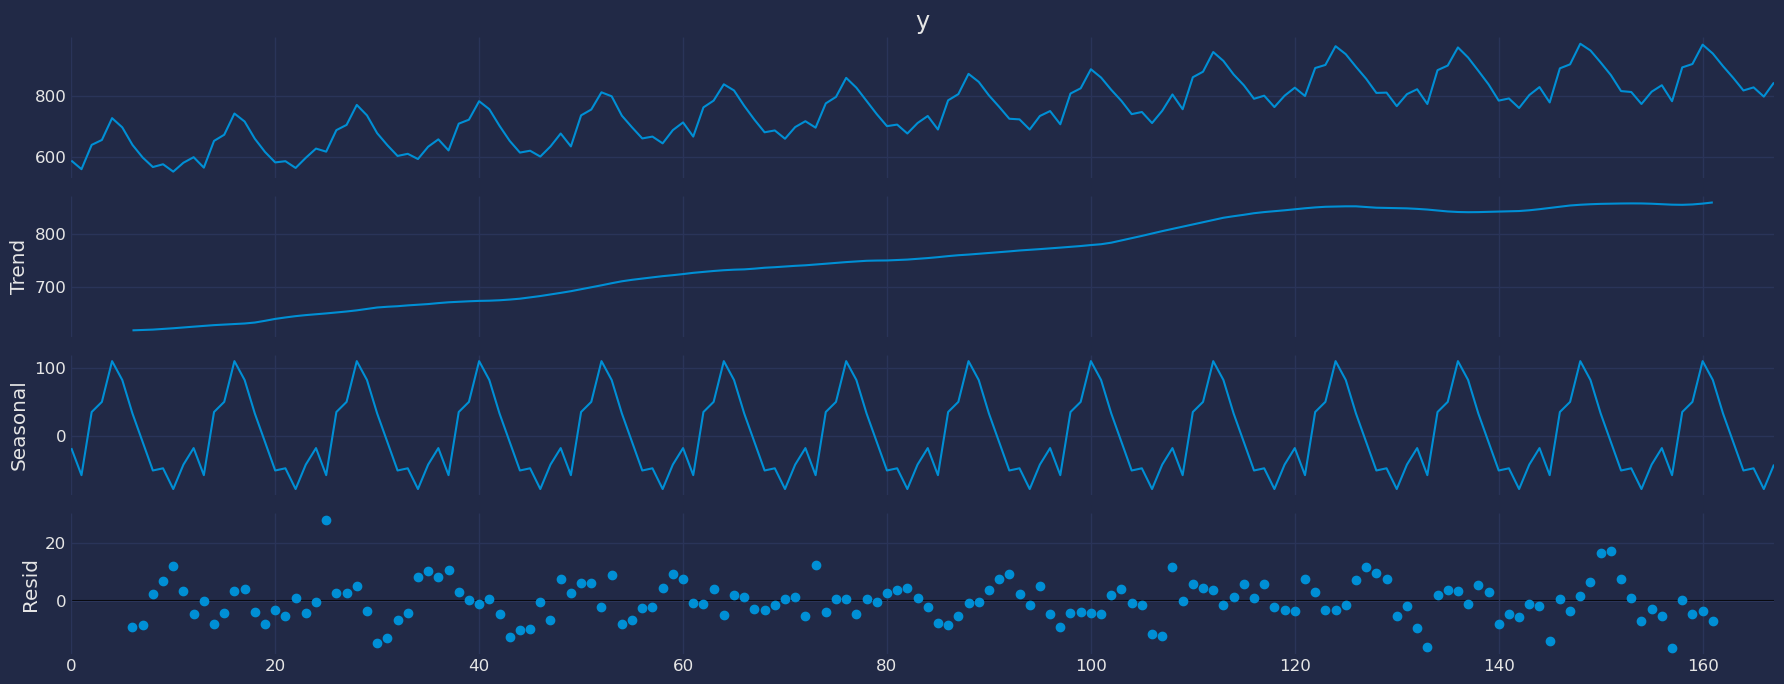

In [10]:
from statsmodels.tsa.seasonal import seasonal_decompose 
a = seasonal_decompose(df["y"], model = "additive", period=12)
a.plot();

### Multiplicative

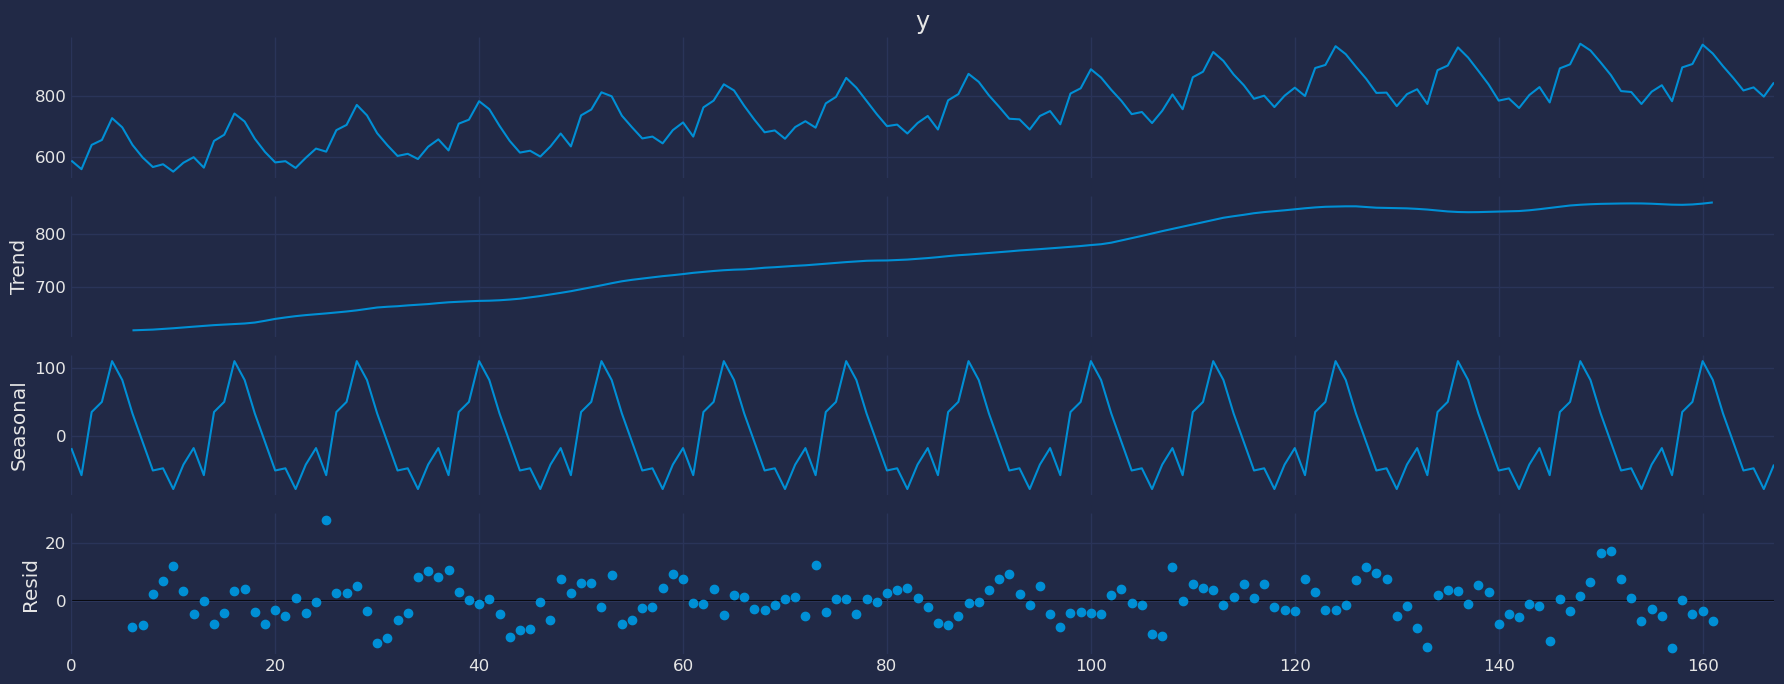

In [11]:
from statsmodels.tsa.seasonal import seasonal_decompose 
a = seasonal_decompose(df["y"], model = "Multiplicative", period=12)
a.plot();

# **6. Split the data into training and testing** <a class="anchor" id="6"></a>

[Table of Contents](#0.1)

Let's divide our data into sets
1. Data to train our `Dynamic Standard Theta Model`
2. Data to test our model

For the test data we will use the last 12 months to test and evaluate the performance of our model.

In [12]:
train = df[df.ds<='1974-12-01'] 
test = df[df.ds>'1974-12-01'] 

In [13]:
train.shape, test.shape

((156, 3), (12, 3))

Now let's plot the training data and the test data.

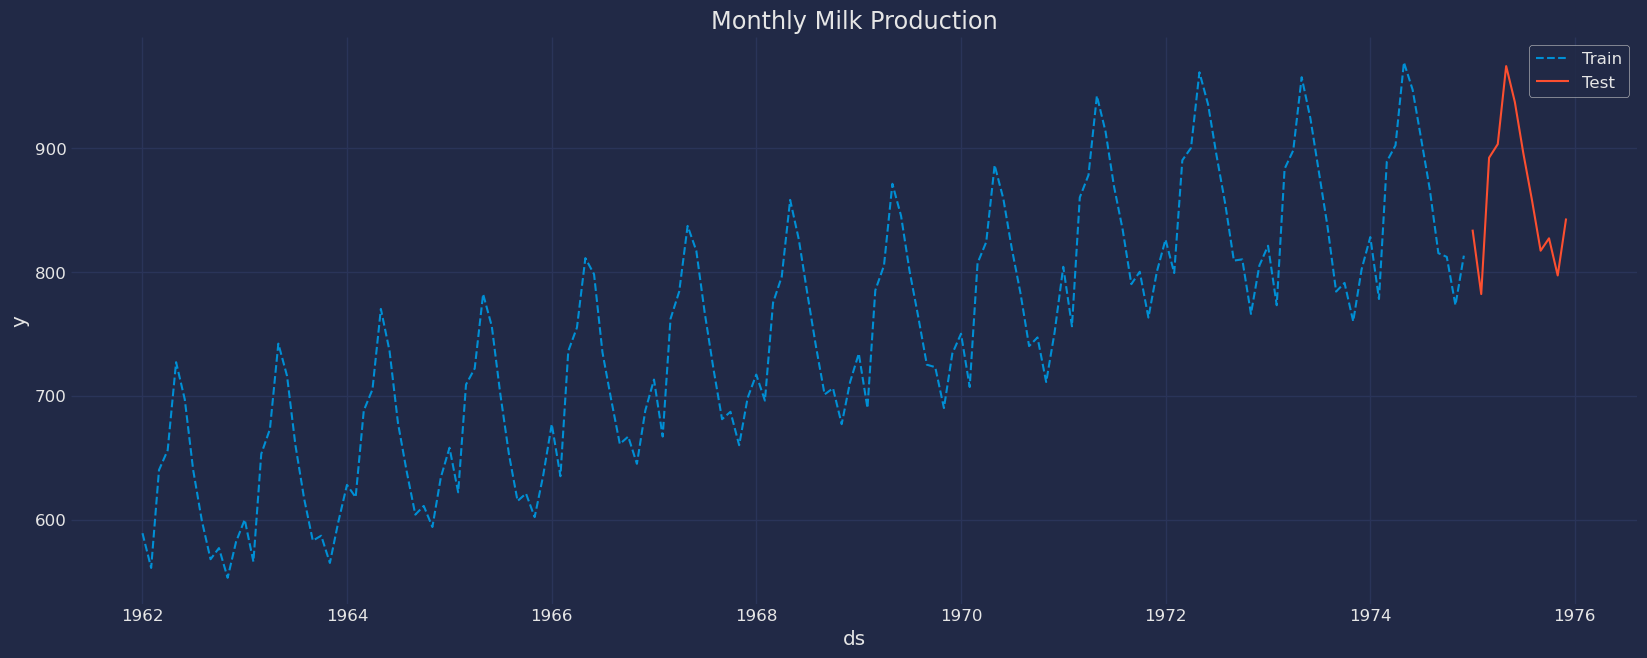

In [14]:
sns.lineplot(train,x="ds", y="y", label="Train", linestyle="--")
sns.lineplot(test, x="ds", y="y", label="Test")
plt.title("Monthly Milk Production")
plt.show()

# **7. Implementation of Standard Theta with StatsForecast** <a class="anchor" id="7"></a>

[Table of Contents](#0.1)

To also know more about the parameters of the functions of the `Dynamic Standard Theta model` you can see it [here](https://nixtla.github.io/statsforecast/src/core/models.html#dynamic-standard-theta-method).

## **7.1 Load libraries**

In [15]:
from statsforecast import StatsForecast
from statsforecast.models import Theta, OptimizedTheta, DynamicTheta

In [16]:
?DynamicTheta

Init signature:
DynamicTheta(
    season_length: int = 1,
    decomposition_type: str = 'multiplicative',
    alias: str = 'DynamicTheta',
)
Docstring:     
Dynamic Standard Theta Method.

**References:**<br>
[Jose A. Fiorucci, Tiago R. Pellegrini, Francisco Louzada, Fotios Petropoulos, Anne B. Koehler (2016). "Models for optimising the theta method and their relationship to state space models". International Journal of Forecasting](https://www.sciencedirect.com/science/article/pii/S0169207016300243)

Parameters
----------
season_length : int
    Number of observations per unit of time. Ex: 24 Hourly data.
decomposition_type : str
    Sesonal decomposition type, 'multiplicative' (default) or 'additive'.
alias : str
    Custom name of the model.
File:           ~/miniconda3/envs/statsforecast/lib/python3.10/site-packages/statsforecast/models.py
Type:           type
Subclasses:     

## **7.2 Building Model**
Import and instantiate the models. Setting the argument is sometimes tricky. This article on [Seasonal periods](https://robjhyndman.com/hyndsight/seasonal-periods/) by the master, Rob Hyndmann, can be useful for `season_length`.


In [17]:
season_length = 12 # Monthly data 
horizon = len(test) # number of predictions

# We call the model that we are going to use
models = [DynamicTheta(season_length=season_length, 
                decomposition_type="additive")] # multiplicative   additive

We fit the models by instantiating a new StatsForecast object with the following parameters:

models: a list of models. Select the models you want from models and import them.

* `freq:` a string indicating the frequency of the data. (See [panda’s available frequencies](https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#offset-aliases).)

* `n_jobs:` n_jobs: int, number of jobs used in the parallel processing, use -1 for all cores.

* `fallback_model:` a model to be used if a model fails.

Any settings are passed into the constructor. Then you call its fit method and pass in the historical data frame.

In [18]:
# Instantiate StatsForecast class as sf
sf = StatsForecast(df=train,
                   models=models,
                   freq='MS', 
                   n_jobs=-1)

## **7.3 Fit the Model**

In [19]:
# fit the models
sf.fit()

StatsForecast(models=[DynamicTheta])

Let's see the results of our `Dynamic Standard Theta model`. We can observe it with the following instruction:

In [20]:
result=sf.fitted_[0,0].model_
result

{'mse': 10.789180969422025,
 'amse': array([ 54.80024565,  86.05803568, 116.12121576]),
 'fit': results(x=array([393.28739991,   0.76875   ]), fn=10.787112115489622, nit=20, simplex=array([[399.92916541,   0.771875  ],
        [393.28739991,   0.76875   ],
        [384.74798713,   0.771875  ]])),
 'residuals': array([-18.24713135, -46.24713135,  17.14019775,  49.01220703,
        121.9788208 ,  82.67987061,  25.4487915 , -11.09313965,
        -42.07873535, -41.60479736, -71.8616333 , -49.2645874 ,
        -27.29528809, -55.0357666 ,  29.36132812,  53.02612305,
        119.35900879,  86.07275391,  27.02038574, -13.31542969,
        -46.15814209, -47.71917725, -71.18035889, -44.8092041 ,
        -14.0715332 , -28.00720215,  18.40008545,  47.16864014,
        113.65618896,  76.45733643,  22.55456543, -10.58435059,
        -46.77215576, -45.06982422, -65.77008057, -36.73968506,
        -18.41137695, -55.19897461,  29.08068848,  45.58953857,
        108.26220703,  83.21356201,  28.10949707,

Let us now visualize the residuals of our models.

As we can see, the result obtained above has an output in a dictionary, to extract each element from the dictionary we are going to use the `.get()` function to extract the element and then we are going to save it in a `pd.DataFrame()`.

In [21]:
residual=pd.DataFrame(result.get("residuals"), columns=["residual Model"])
residual

,residual Model
0,-18.247131
1,-46.247131
2,17.140198
3,49.012207
4,121.978821
...,...
151,-7.586487
152,-63.162537
153,-58.941711
154,-91.055420


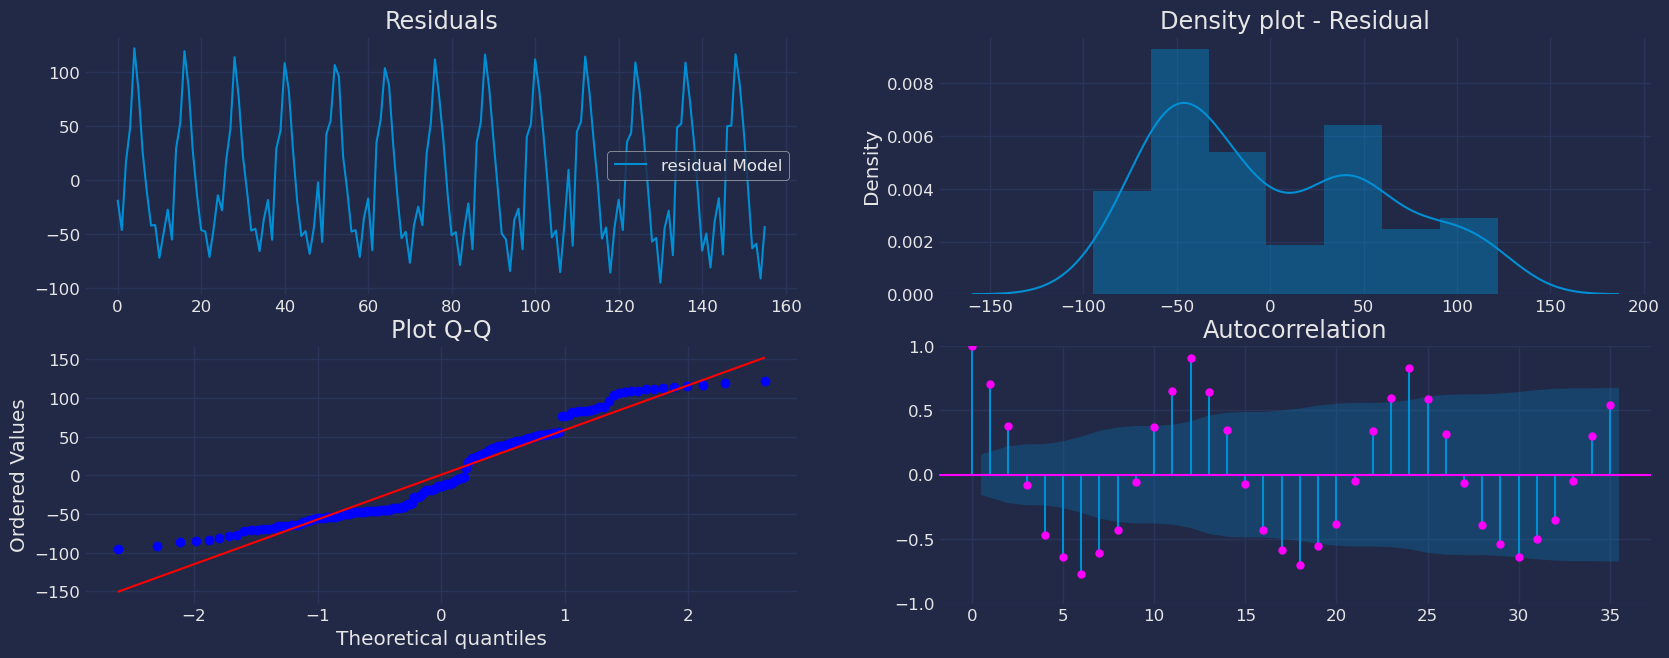

In [22]:
fig, axs = plt.subplots(nrows=2, ncols=2)

# plot[1,1]
residual.plot(ax=axs[0,0])
axs[0,0].set_title("Residuals");

# plot
sns.distplot(residual, ax=axs[0,1]);
axs[0,1].set_title("Density plot - Residual");

# plot
stats.probplot(residual["residual Model"], dist="norm", plot=axs[1,0])
axs[1,0].set_title('Plot Q-Q')

# plot
plot_acf(residual,  lags=35, ax=axs[1,1],color="fuchsia")
axs[1,1].set_title("Autocorrelation");

plt.show();

## **7.4 Forecast Method**

If you want to gain speed in productive settings where you have multiple series or models we recommend using the `StatsForecast.forecast` method instead of `.fit` and `.predict`.

The main difference is that the `.forecast` doest not store the fitted values and is highly scalable in distributed environments.

The forecast method takes two arguments: forecasts next `h` (horizon) and `level`.

* `h (int):` represents the forecast h steps into the future. In this case, 12 months ahead.

* `level (list of floats):` this optional parameter is used for probabilistic forecasting. Set the level (or confidence percentile) of your prediction interval. For example, `level=[90]` means that the model expects the real value to be inside that interval 90% of the times.

The forecast object here is a new data frame that includes a column with the name of the model and the y hat values, as well as columns for the uncertainty intervals. Depending on your computer, this step should take around 1min. (If you want to speed things up to a couple of seconds, remove the AutoModels like `ARIMA` and `Theta`)

In [23]:
# Prediction
Y_hat = sf.forecast(horizon, fitted=True)

Y_hat

,ds,DynamicTheta
unique_id,,
1,1975-01-01,838.531555
1,1975-02-01,800.154968
1,1975-03-01,893.430786
1,1975-04-01,909.734131
1,1975-05-01,971.044128
1,1975-06-01,944.197632
1,1975-07-01,893.420349
1,1975-08-01,851.965881
1,1975-09-01,811.306396


In [24]:
values=sf.forecast_fitted_values()
values.head()

,ds,y,DynamicTheta
unique_id,,,
1,1962-01-01,589.0,607.247131
1,1962-02-01,561.0,607.247131
1,1962-03-01,640.0,622.859802
1,1962-04-01,656.0,606.987793
1,1962-05-01,727.0,605.021179


In [25]:
StatsForecast.plot(values)

Adding 95% confidence interval with the forecast method

In [26]:
sf.forecast(h=horizon, level=[95])

,ds,DynamicTheta,DynamicTheta-lo-95,DynamicTheta-hi-95
unique_id,,,,
1,1975-01-01,838.531555,741.237366,954.407166
1,1975-02-01,800.154968,640.697327,945.673157
1,1975-03-01,893.430786,703.900635,1065.418579
1,1975-04-01,909.734131,726.484985,1104.446533
1,1975-05-01,971.044128,751.521790,1180.438843
1,1975-06-01,944.197632,718.857361,1161.713745
1,1975-07-01,893.420349,625.033813,1103.173096
1,1975-08-01,851.965881,585.391602,1106.013184
1,1975-09-01,811.306396,538.627930,1080.363892


In [27]:
Y_hat=Y_hat.reset_index()
Y_hat

,unique_id,ds,DynamicTheta
0,1,1975-01-01,838.531555
1,1,1975-02-01,800.154968
2,1,1975-03-01,893.430786
3,1,1975-04-01,909.734131
4,1,1975-05-01,971.044128
5,1,1975-06-01,944.197632
6,1,1975-07-01,893.420349
7,1,1975-08-01,851.965881
8,1,1975-09-01,811.306396
9,1,1975-10-01,815.959351


In [28]:
# Merge the forecasts with the true values
Y_hat1 = test.merge(Y_hat, how='left', on=['unique_id', 'ds'])
Y_hat1

,ds,y,unique_id,DynamicTheta
0,1975-01-01,834,1,838.531555
1,1975-02-01,782,1,800.154968
2,1975-03-01,892,1,893.430786
3,1975-04-01,903,1,909.734131
4,1975-05-01,966,1,971.044128
5,1975-06-01,937,1,944.197632
6,1975-07-01,896,1,893.420349
7,1975-08-01,858,1,851.965881
8,1975-09-01,817,1,811.306396
9,1975-10-01,827,1,815.959351


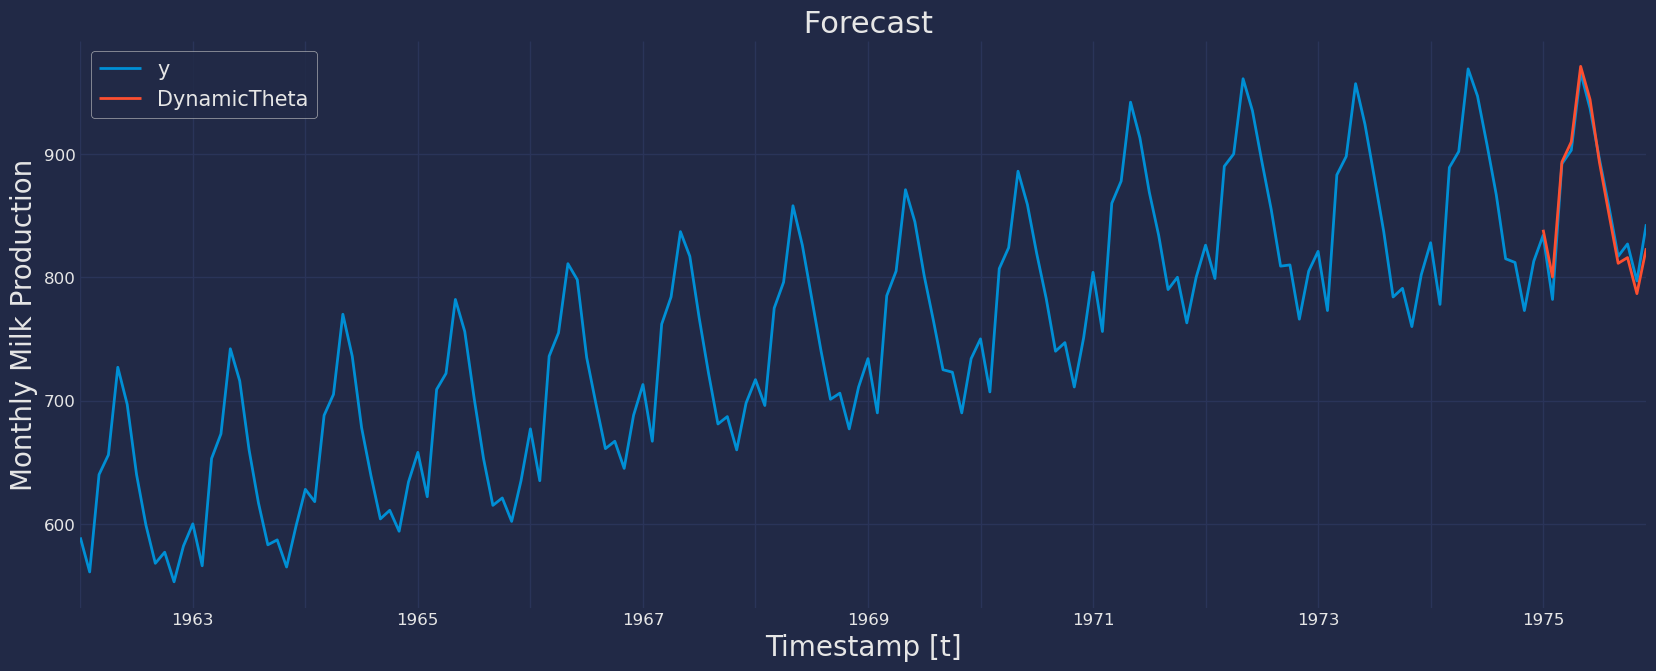

In [29]:
# Merge the forecasts with the true values


fig, ax = plt.subplots(1, 1)
plot_df = pd.concat([train, Y_hat1]).set_index('ds')
plot_df[['y', "DynamicTheta"]].plot(ax=ax, linewidth=2)
ax.set_title(' Forecast', fontsize=22)
ax.set_ylabel('Monthly Milk Production', fontsize=20)
ax.set_xlabel('Timestamp [t]', fontsize=20)
ax.legend(prop={'size': 15})
ax.grid(True)

## **7.5 Predict method with confidence interval**

To generate forecasts use the predict method.

The predict method takes two arguments: forecasts the next `h` (for horizon) and `level`.

* `h (int):` represents the forecast h steps into the future. In this case, 12 months ahead.

* `level (list of floats):` this optional parameter is used for probabilistic forecasting. Set the level (or confidence percentile) of your prediction interval. For example, `level=[95]` means that the model expects the real value to be inside that interval 95% of the times.

The forecast object here is a new data frame that includes a column with the name of the model and the y hat values, as well as columns for the uncertainty intervals.

This step should take less than 1 second.

In [30]:
sf.predict(h=horizon) 

,ds,DynamicTheta
unique_id,,
1,1975-01-01,838.531555
1,1975-02-01,800.154968
1,1975-03-01,893.430786
1,1975-04-01,909.734131
1,1975-05-01,971.044128
1,1975-06-01,944.197632
1,1975-07-01,893.420349
1,1975-08-01,851.965881
1,1975-09-01,811.306396


In [31]:
forecast_df = sf.predict(h=horizon, level=[80,95]) 

forecast_df

,ds,DynamicTheta,DynamicTheta-lo-80,DynamicTheta-hi-80,DynamicTheta-lo-95,DynamicTheta-hi-95
unique_id,,,,,,
1,1975-01-01,838.531555,765.423828,927.285400,741.237366,954.407166
1,1975-02-01,800.154968,701.099854,899.316223,640.697327,945.673157
1,1975-03-01,893.430786,758.326416,1007.631287,703.900635,1065.418579
1,1975-04-01,909.734131,776.017578,1009.272217,726.484985,1104.446533
1,1975-05-01,971.044128,833.134399,1101.602051,751.521790,1180.438843
1,1975-06-01,944.197632,789.890869,1103.036621,718.857361,1161.713745
1,1975-07-01,893.420349,719.826965,1053.442627,625.033813,1103.173096
1,1975-08-01,851.965881,662.746094,1053.818726,585.391602,1106.013184
1,1975-09-01,811.306396,609.474487,998.779785,538.627930,1080.363892


We can join the forecast result with the historical data using the pandas function `pd.concat()`, and then be able to use this result for graphing.

In [32]:
pd.concat([df, forecast_df]).set_index('ds')

,y,unique_id,DynamicTheta,DynamicTheta-lo-80,DynamicTheta-hi-80,DynamicTheta-lo-95,DynamicTheta-hi-95
ds,,,,,,,
1962-01-01,589.0,1,NaN,NaN,NaN,NaN,NaN
1962-02-01,561.0,1,NaN,NaN,NaN,NaN,NaN
1962-03-01,640.0,1,NaN,NaN,NaN,NaN,NaN
1962-04-01,656.0,1,NaN,NaN,NaN,NaN,NaN
1962-05-01,727.0,1,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
1975-08-01,NaN,NaN,851.965881,662.746094,1053.818726,585.391602,1106.013184
1975-09-01,NaN,NaN,811.306396,609.474487,998.779785,538.627930,1080.363892
1975-10-01,NaN,NaN,815.959351,608.699524,992.552856,536.423035,1086.643677


Now let's visualize the result of our forecast and the historical data of our time series, also let's draw the confidence interval that we have obtained when making the prediction with 95% confidence.

In [33]:
def plot_forecasts(y_hist, y_true, y_pred, models):
    _, ax = plt.subplots(1, 1, figsize = (20, 7))
    y_true = y_true.merge(y_pred, how='left', on=['unique_id', 'ds'])
    df_plot = pd.concat([y_hist, y_true]).set_index('ds').tail(12*10)
    df_plot[['y'] + models].plot(ax=ax, linewidth=3 , )
    colors = ['green', "lime"]
  # Specify graph features:
    ax.fill_between(df_plot.index, 
                df_plot['DynamicTheta-lo-80'], 
                df_plot['DynamicTheta-lo-80'],
                alpha=.20,
                color='orange',
                label='DynamicTheta_level_80')
    ax.fill_between(df_plot.index, 
                df_plot['DynamicTheta-lo-95'], 
                df_plot['DynamicTheta-hi-95'],
                alpha=.3,
                color='lime',
                label='DynamicTheta_level_95')
    ax.set_title('', fontsize=22)
    ax.set_ylabel("Montly Mil Production", fontsize=20)
    ax.set_xlabel('Month-Days', fontsize=20)
    ax.legend(prop={'size': 20})
    ax.grid(True)
    plt.show()

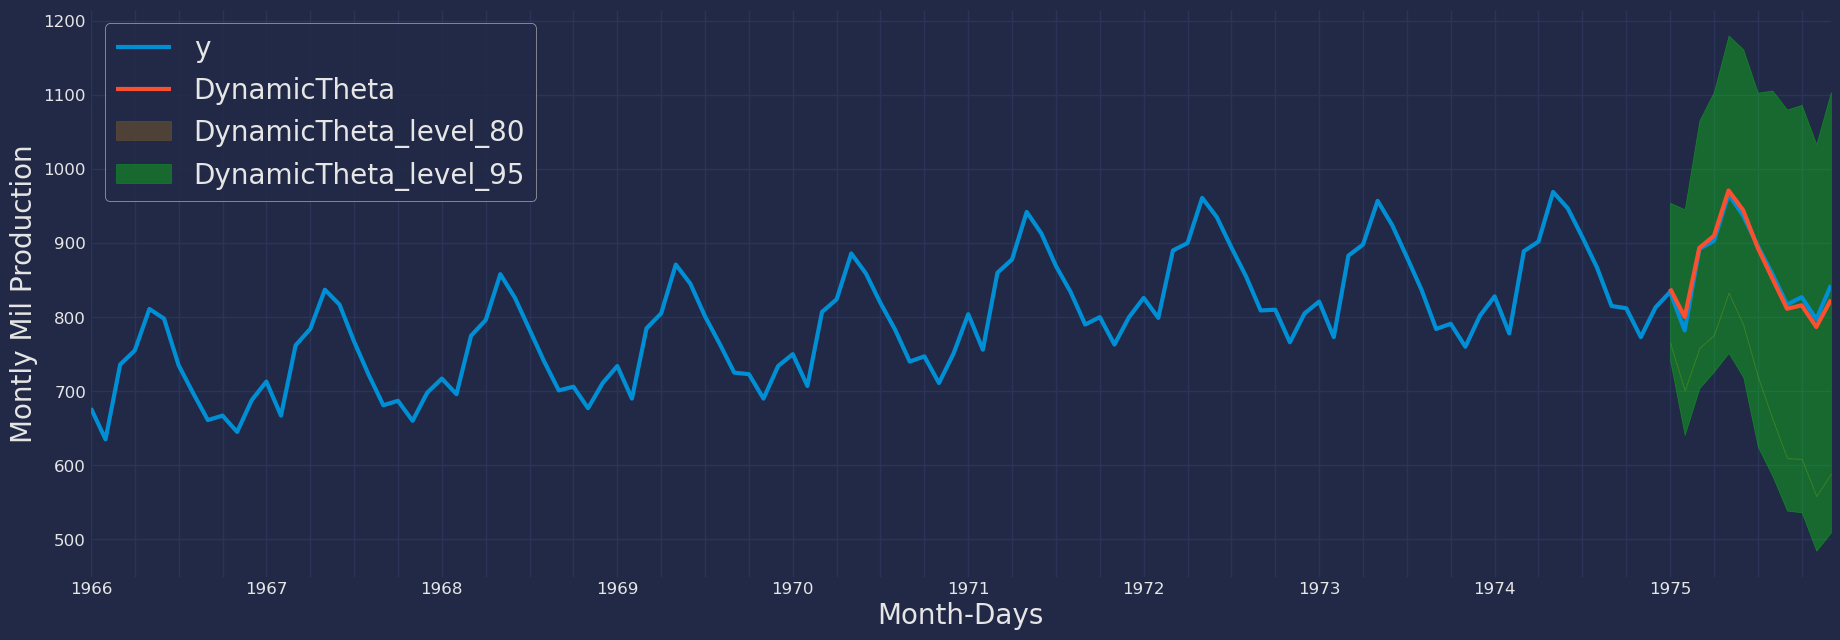

In [34]:
plot_forecasts(train, test, forecast_df, models=['DynamicTheta'])

Let's plot the same graph using the plot function that comes in `Statsforecast`, as shown below.

In [35]:
sf.plot(df, forecast_df, level=[95])

# **8. Evaluate the model’s performance** <a class="anchor" id="8"></a>

[Table of Contents](#0.1)

In previous steps, we’ve taken our historical data to predict the future. However, to asses its accuracy we would also like to know how the model would have performed in the past. To assess the accuracy and robustness of your models on your data perform Cross-Validation.

With time series data, Cross Validation is done by defining a sliding window across the historical data and predicting the period following it. This form of cross-validation allows us to arrive at a better estimation of our model’s predictive abilities across a wider range of temporal instances while also keeping the data in the training set contiguous as is required by our models.

The following graph depicts such a Cross Validation Strategy:

![](https://raw.githubusercontent.com/Nixtla/statsforecast/main/nbs/imgs/ChainedWindows.gif)

## **8.1 Perform time series cross-validation**

Cross-validation of time series models is considered a best practice but most implementations are very slow. The statsforecast library implements cross-validation as a distributed operation, making the process less time-consuming to perform. If you have big datasets you can also perform Cross Validation in a distributed cluster using Ray, Dask or Spark.

In this case, we want to evaluate the performance of each model for the last 5 months `(n_windows=5)`, forecasting every second months `(step_size=12)`. Depending on your computer, this step should take around 1 min.

The cross_validation method from the StatsForecast class takes the following arguments.

* `df:` training data frame

* `h (int):` represents h steps into the future that are being forecasted. In this case, 12 months ahead.

* `step_size (int):` step size between each window. In other words: how often do you want to run the forecasting processes.

* `n_windows(int):` number of windows used for cross validation. In other words: what number of forecasting processes in the past do you want to evaluate.

In [36]:
crossvalidation_df = sf.cross_validation(df=train,
                                         h=horizon,
                                         step_size=12,
                                         n_windows=3)

The crossvaldation_df object is a new data frame that includes the following columns:

*  `unique_id:` index. If you dont like working with index just run crossvalidation_df.resetindex()
* `ds:` datestamp or temporal index
* `cutoff:` the last datestamp or temporal index for the n_windows.
* `y:` true value
* `"model":` columns with the model’s name and fitted value.

In [37]:
crossvalidation_df

,ds,cutoff,y,DynamicTheta
unique_id,,,,
1,1972-01-01,1971-12-01,826.0,827.107239
1,1972-02-01,1971-12-01,799.0,789.924194
1,1972-03-01,1971-12-01,890.0,879.664429
1,1972-04-01,1971-12-01,900.0,897.128784
1,1972-05-01,1971-12-01,961.0,957.983521
1,1972-06-01,1971-12-01,935.0,931.084900
1,1972-07-01,1971-12-01,894.0,878.645630
1,1972-08-01,1971-12-01,855.0,836.498901
1,1972-09-01,1971-12-01,809.0,798.218445


We’ll now plot the forecast for each cutoff period. To make the plots clearer, we’ll rename the actual values in each period.

In [38]:
crossvalidation_df.rename(columns = {'y' : 'actual'}, inplace = True) # rename actual values 

cutoff = crossvalidation_df['cutoff'].unique()

for k in range(len(cutoff)): 
    cv = crossvalidation_df[crossvalidation_df['cutoff'] == cutoff[k]]
    StatsForecast.plot(df, cv.loc[:, cv.columns != 'cutoff'])

# **9. Evaluate the model** <a class="anchor" id="9"></a>

[Table of Contents](#0.1)

We can now compute the accuracy of the forecast using an appropiate accuracy metric. Here we’ll use the Root Mean Squared Error (RMSE). To do this, we first need to `install datasetsforecast`, a Python library developed **by Nixtla** that includes a function to compute the RMSE.

`pip install datasetsforecast`

In [39]:
from datasetsforecast.losses import rmse

The function to compute the RMSE takes two arguments:

1. The actual values.
2. The forecasts, in this case, `Dynamic Standard Theta model`.

In [40]:
rmse = rmse(crossvalidation_df['actual'], crossvalidation_df["DynamicTheta"])
print("RMSE using cross-validation: ", rmse)

RMSE using cross-validation:  12.610596


As you have noticed, we have used the cross validation results to perform the evaluation of our model.

Now we are going to evaluate our model with the results of the predictions, we will use different types of metrics `MAE, MAPE, MASE, RMSE, SMAPE` to evaluate the `accuracy`.

In [41]:
from datasetsforecast.losses import (mae, mape, mase, rmse, smape)

In [42]:
def evaluate_performace(y_hist, y_true, y_pred, models):
    y_true = y_true.merge(y_pred, how='left', on=['unique_id', 'ds'])
    evaluation = {}
    for model in models:
        evaluation[model] = {}
        for metric in [mase, mae, mape, rmse, smape]:
            metric_name = metric.__name__
            if metric_name == 'mase':
                evaluation[model][metric_name] = metric(y_true['y'].values, 
                                                 y_true[model].values, 
                                                 y_hist['y'].values, seasonality=12)
            else:
                evaluation[model][metric_name] = metric(y_true['y'].values, y_true[model].values)
    return pd.DataFrame(evaluation).T

In [43]:
evaluate_performace(train, test, Y_hat, models=["DynamicTheta"])

,mae,mape,mase,rmse,smape
DynamicTheta,8.182119,0.97361,0.367965,9.817624,0.974804


# **10. References** <a class="anchor" id="10"></a>

[Table of Contents](#0)

1. Kostas I. Nikolopoulos, Dimitrios D. Thomakos. Forecasting with the Theta Method-Theory and Applications. 2019 John Wiley & Sons Ltd.
2. [Jose A. Fiorucci, Tiago R. Pellegrini, Francisco Louzada, Fotios Petropoulos, Anne B. Koehler (2016). “Models for optimising the theta method and their relationship to state space models”. International Journal of Forecasting](https://www.sciencedirect.com/science/article/pii/S0169207016300243).
3. [Nixtla Parameters](https://nixtla.github.io/statsforecast/src/core/models.html#autotheta).
4. [Pandas available frequencies](https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#offset-aliases).
5. [Rob J. Hyndman and George Athanasopoulos (2018). “Forecasting principles and practice, Time series cross-validation”.](https://otexts.com/fpp3/tscv.html).
6. [Seasonal periods- Rob J Hyndman](https://robjhyndman.com/hyndsight/seasonal-periods/).


